In [ ]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as clr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
with np.load('drive/My Drive/Deep Learning/exercise_4/prediction-challenge-02-data.npz') as fh:
    x_train = fh['x_train']
    y_train = fh['y_train']
    x_test = fh['x_test']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

# TEST DATA: INPUT (x) ONLY
print(x_test.shape, x_test.dtype)

(3000, 32, 32, 3) float32
(3000,) float64
(300, 32, 32, 3) float32


In [ ]:
x_train = np.transpose(x_train, axes=[0, 3, 1, 2])
x_test = np.transpose(x_test, axes=[0, 3, 1, 2])

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_test.shape, x_test.dtype)

(3000, 3, 32, 32) float32
(3000,) float64
(300, 3, 32, 32) float32


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)

In [ ]:
BATCH_SIZE = 32

torch_x_train = torch.from_numpy(x_train).to(device)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)

torch_x_val = torch.from_numpy(x_val).to(device)
torch_y_val = torch.from_numpy(y_val).type(torch.LongTensor).to(device)

train = torch.utils.data.TensorDataset(torch_x_train,torch_y_train)
validate = torch.utils.data.TensorDataset(torch_x_val,torch_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(validate, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,   128,  3)
        self.conv2 = nn.Conv2d(128,  256, 3)
        self.conv3 = nn.Conv2d(256, 512, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.2)


    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.conv3(x))))
        x = x.view(-1, 512 * 2 * 2)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net.train()                                 # prep model for training

max_epoch = 300

state_dicts = {}

train_loss = np.zeros(max_epoch)
val_loss = np.zeros(max_epoch)

for epoch in range(max_epoch):  

    for X, y in train_loader.items():    
        net.zero_grad()                     # zero the parameter gradients
        output = net(X)                     # forward pass
        loss = criterion(output, y)         # calculate loss
        loss.backward()                     # backward pass
        optimizer.step()                    # optimize parameters
        train_loss[epoch] += loss
    train_loss[epoch] /= len(train_loader)  # normalizing the loss by the total number of train batches

    with torch.no_grad():
        for X, y in val_loader:
            output = net(X)
            loss = criterion(output, y) 
            val_loss[epoch] += loss
        val_loss[epoch] /= len(val_loader)

    state_dicts[epoch] = net.state_dict()   # save network parameters at each epoch

    print('epoch %d:\ttrain loss: %.5f\tvalidation loss: %.5f'%(epoch, train_loss[epoch], val_loss[epoch])) 

    if epoch > 100:
        if np.polyfit(np.arange(30),val_loss[epoch-30:epoch], deg=1)[0] > 0.01:
            break                           # break if validation loss shows an increasing trend


epoch 0:	train loss: 2.02586	validation loss: 1.31305
epoch 1:	train loss: 1.14971	validation loss: 1.12512
epoch 2:	train loss: 1.12813	validation loss: 1.13419
epoch 3:	train loss: 1.12056	validation loss: 1.11127
epoch 4:	train loss: 1.11289	validation loss: 1.11148
epoch 5:	train loss: 1.10979	validation loss: 1.12641
epoch 6:	train loss: 1.10953	validation loss: 1.11259
epoch 7:	train loss: 1.10634	validation loss: 1.11381
epoch 8:	train loss: 1.10147	validation loss: 1.10924
epoch 9:	train loss: 1.10187	validation loss: 1.11916
epoch 10:	train loss: 1.10246	validation loss: 1.11355
epoch 11:	train loss: 1.10110	validation loss: 1.11920
epoch 12:	train loss: 1.09916	validation loss: 1.10394
epoch 13:	train loss: 1.09373	validation loss: 1.11571
epoch 14:	train loss: 1.09545	validation loss: 1.09182
epoch 15:	train loss: 1.09516	validation loss: 1.10982
epoch 16:	train loss: 1.09419	validation loss: 1.10710
epoch 17:	train loss: 1.09165	validation loss: 1.10003
epoch 18:	train loss

In [ ]:
idx = val_loss > 0
val_loss = val_loss[idx]
train_loss = train_loss[idx]

In [ ]:
best_epoch = np.argmin(val_loss)                # select the epoch with lowest validation loss
net.load_state_dict(state_dicts[best_epoch]);  

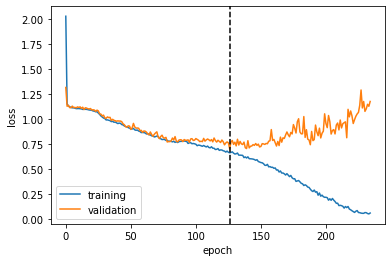

In [ ]:
f, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.axvline(best_epoch, c='k', ls='--')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='lower left');

In [ ]:
net.cpu().eval()

output_train = net(torch_x_train.cpu()).cpu().detach().numpy().argmax(axis=1)
output_val = net(torch_x_val.cpu()).cpu().detach().numpy().argmax(axis=1)

print('Training accuracy:\t%.3f'%(sum(output_train == y_train)/len(y_train)))
print('Validation accuracy:\t%.3f'%(sum(output_val == y_val)/len(y_val)))

Training accuracy:	1.000
Validation accuracy:	0.740


In [ ]:
confusion_matrix = np.zeros((3,3))
for real, pred in zip(y_val,output_val):
    confusion_matrix[int(real),int(pred)] += 1
confusion_matrix

array([[48., 32., 13.],
       [17., 68.,  7.],
       [ 9., 10., 96.]])

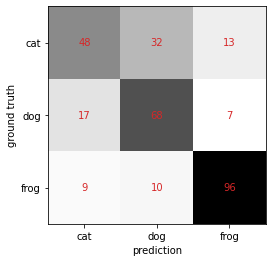

In [ ]:
f, ax = plt.subplots()
ax.imshow(confusion_matrix, cmap='binary')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['cat', 'dog', 'frog'])
ax.set_yticks([0,1,2])
ax.set_yticklabels(['cat', 'dog', 'frog'])
ax.set_xlabel('prediction')
ax.set_ylabel('ground truth')
for i in range(3):
    for j in range(3):
        ax.annotate(int(confusion_matrix[i,j]), (j,i), c='C3', ha='center', va='center')

In [ ]:
prediction = net(torch.from_numpy(x_test)).cpu().detach().numpy().argmax(axis=1)
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('drive/My Drive/Deep Learning/exercise_4/prediction_0.740.npy', prediction)